In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import dataGathandMan
from minisom import MiniSom
from itertools import product
import pickle

np.random.seed(42)

In [2]:
# Get all image paths in the folder
folder_path = "/home/tcarlyon/classes/aiclass/RawData/"
image_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.tiff')]
square_size = 128
numpatches = 2048*2
# Randomly sample patches
#data = dataGathandMan.load_images(image_paths)
data = dataGathandMan.random_sample_patches(image_paths, square_size, numpatches)
# Ensure the data shape is correct
print(f"data shape: {data.shape}")
image_width = data.shape[-3]
image_height = data.shape[-2]
image_features = data.shape[-1]

Processing image: /home/tcarlyon/classes/aiclass/RawData/TreeCover.tiff
Processing image: /home/tcarlyon/classes/aiclass/RawData/ImpDesc.tiff
Processing image: /home/tcarlyon/classes/aiclass/RawData/IR.tiff
Processing image: /home/tcarlyon/classes/aiclass/RawData/FracImp.tiff
Processing image: /home/tcarlyon/classes/aiclass/RawData/Height.tiff
Image shape: (31913, 47758, 1), Slope shape: (31913, 47758, 1)
Processing image: /home/tcarlyon/classes/aiclass/RawData/Visible.tiff
all_patches shape: (4096, 128, 128, 13)
data shape: (4096, 128, 128, 13)


In [4]:
# Reshape the data for clustering
reshaped_data = data.reshape(square_size ** 2 * numpatches, image_features)
print(data.shape)
print(f"first data point before reshape: {data[0, 0, :]}")
print(f"first data point after reshape: {reshaped_data[0]}")
print(f"last data point before reshape: {data[-1, -1, :]}")
print(f"last data point after reshape: {reshaped_data[-1]}")

(4096, 128, 128, 13)
first data point before reshape: [[ 10.         107.          10.         ...   0.2745098    0.36078431
    0.27843137]
 [ 31.         118.          31.         ...   0.2745098    0.36078431
    0.27843137]
 [ 42.         121.          42.         ...   0.26666667   0.35294118
    0.27058824]
 ...
 [ 21.         110.          21.         ...   0.25098039   0.33333333
    0.26666667]
 [ 42.         121.          42.         ...   0.24705882   0.32941176
    0.2627451 ]
 [ 42.         121.          42.         ...   0.25490196   0.3372549
    0.27058824]]
first data point after reshape: [1.00000000e+01 1.07000000e+02 1.00000000e+01 0.00000000e+00
 4.82352941e-01 5.01960784e-01 1.33333333e-01 0.00000000e+00
 3.73953313e-04 1.19751422e-02 2.74509804e-01 3.60784314e-01
 2.78431373e-01]
last data point before reshape: [[ 19.         108.          19.         ...   0.24705882   0.34509804
    0.28235294]
 [ 19.         108.          19.         ...   0.25882353   0.372549

In [3]:
# SOM hyperparameters

# set som lattice dimensions (i.e., number of nodes)
som_grid_rows = 5
som_grid_columns = 5

# number of weights per node
input_length = image_features

# Spread of the neighborhood function, needs to be adequate to the dimensions
# of the map. (rows/columns minus 1 usually)
sigma = 0.5

# initial learning rate (at the iteration t we have learning_rate(t) =
# learning_rate / (1 + t/T) where T is #num_iteration/2)
learning_rate = 0.1

# Function that reduces learning_rate at each iteration
# Possible values: 'inverse_decay_to_zero', 'linear_decay_to_zero', 'asymptotic_decay'
# 'inverse_decay_to_zero' == > C = max_iter / 100.0; where, learning_rate * C / (C + t)
# 'linear_decay_to_zero' == > learning_rate * (1 - t / max_iter)
# 'asymptotic_decay' == > dynamic_parameter / (1 + t / (max_iter / 2))
# ^^Decay function of the learning process and sigma that decays these values asymptotically to 1/3 of their original values.
decay_function='inverse_decay_to_zero'

# Function that reduces sigma at each iteration.
# Possible values: 'inverse_decay_to_one', 'linear_decay_to_one', 'asymptotic_decay'
# 'inverse_decay_to_one' == > C = (sigma - 1) / max_iter; where, sigma / (1 + (t * C))
# 'linear_decay_to_one' == > sigma + (t * (1 - sigma) / max_iter)
sigma_decay_function='inverse_decay_to_one'

# Function that weights the neighborhood of a position in the map.
# Possible values: 'gaussian', 'mexican_hat', 'bubble', 'triangle',
# which takes in sigma.
neighborhood_function = 'gaussian'

# Topology of the map; Possible values: 'rectangular', 'hexagonal'
topology = 'rectangular'

# Distance used to activate the map; Possible values: 'euclidean', 'cosine', 'manhattan', 'chebyshev'
activation_distance = 'euclidean'

# Random seed to use for reproducibility. Using 1.
random_seed = 1

In [5]:
# lets create our som object with preset hyperparameters
som = MiniSom(
            som_grid_rows,
            som_grid_columns,
            input_length,
            sigma,
            learning_rate,
            decay_function,
            neighborhood_function,
            topology,
            activation_distance,
            random_seed,
            sigma_decay_function
            )
som

In [ ]:
# some training hyperparameters
epochs = 100
random_order = True
verbose = True

# let's initialize the weights
som.random_weights_init(reshaped_data)
# now train!
errors = []
for epoch in range(epochs):
    som.train(reshaped_data, 1, random_order, verbose)
    quantization_error = som.quantization_error(reshaped_data)
    errors.append(quantization_error)

# saving the som in the file som.p
with open('som.p', 'wb') as outfile:
    pickle.dump(som, outfile)

# Plot the training validation curve
plt.figure()
plt.plot(range(epochs), errors, label="Quantization Error")
plt.xlabel("Epoch")
plt.ylabel("Quantization Error")
plt.title("Training Validation Curve")
plt.legend()
plt.show()

 [ 1 / 1 ] 100% - 0:00:00 left 

/home/tcarlyon/miniconda3/envs/keras-tf-v2025/lib/python3.12/site-packages/minisom.py:631: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)



 quantization error: 5.428803715967641
 [ 1 / 1 ] 100% - 0:00:00 left 
 quantization error: 5.369256388823741
 [ 1 / 1 ] 100% - 0:00:00 left 
 quantization error: 5.314674242086433
 [ 1 / 1 ] 100% - 0:00:00 left 
 quantization error: 5.266834367999151
 [ 1 / 1 ] 100% - 0:00:00 left 
 quantization error: 5.216992357348534
 [ 1 / 1 ] 100% - 0:00:00 left 
 quantization error: 5.162710038031921
 [ 1 / 1 ] 100% - 0:00:00 left 
 quantization error: 5.114026064586635
 [ 1 / 1 ] 100% - 0:00:00 left 
 quantization error: 5.070537647190041
 [ 1 / 1 ] 100% - 0:00:00 left 
 quantization error: 5.030225788483674
 [ 1 / 1 ] 100% - 0:00:00 left 
 quantization error: 4.98339952300793
 [ 1 / 1 ] 100% - 0:00:00 left 
 quantization error: 4.937119602955752
 [ 1 / 1 ] 100% - 0:00:00 left 
 quantization error: 4.8944942211870215
 [ 1 / 1 ] 100% - 0:00:00 left 
 quantization error: 4.8528647885863165
 [ 1 / 1 ] 100% - 0:00:00 left 
 quantization error: 4.815650869682847
 [ 1 / 1 ] 100% - 0:00:00 left 
 qua

In [5]:
# Load the SOM from the file som.p
with open('som.p', 'rb') as infile:
    som = pickle.load(infile)

print("SOM loaded successfully.")

SOM loaded successfully.


random_all_patches shape: (4096, 128, 128, 13)


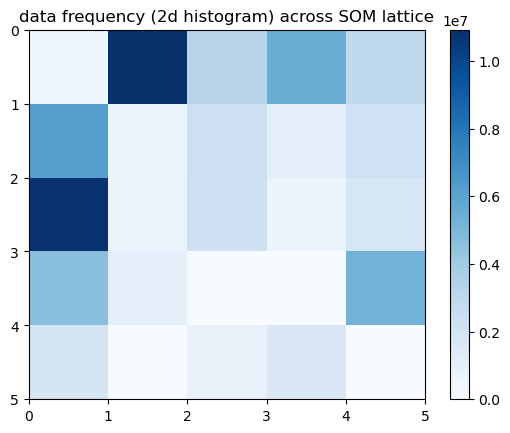

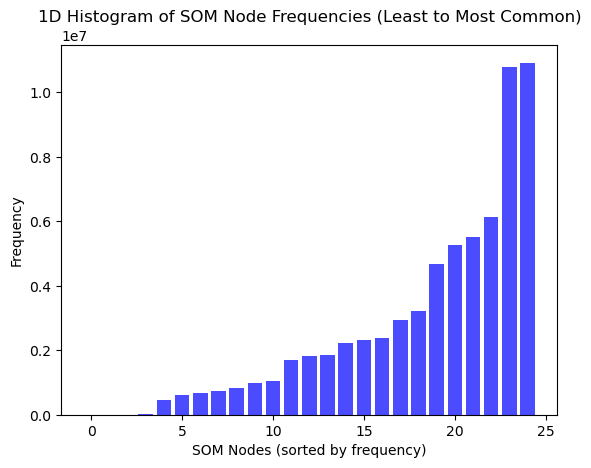

In [6]:
print(f"random_all_patches shape: {data.shape}")
plt.figure()
frequencies = som.activation_response(data.reshape(numpatches * square_size ** 2, data.shape[-1]))
plt.pcolormesh(frequencies, cmap='Blues')
plt.colorbar()
plt.title("data frequency (2d histogram) across SOM lattice", fontsize=12)
plt.ylim(som_grid_rows, 0)  # flip the y axis to be the same as composite map axes later
plt.show()

# Flatten the 2D frequency array into 1D
frequencies_flat = frequencies.flatten()
# Sort the frequencies from least common to most common
sorted_frequencies = np.sort(frequencies_flat)

# Plot the sorted frequencies as a 1D histogram
plt.figure()
plt.bar(range(len(sorted_frequencies)), sorted_frequencies, color='blue', alpha=0.7)
plt.xlabel("SOM Nodes (sorted by frequency)")
plt.ylabel("Frequency")
plt.title("1D Histogram of SOM Node Frequencies (Least to Most Common)")
plt.show()

In [7]:
# grabbing indices from SOM

# create an empty dictionary using the rows and columns of SOM
keys = [i for i in product(range(som_grid_rows), range(som_grid_columns))]
winmap = {key: [] for key in keys}

# grab the indices for the data within the SOM lattice
for i, x in enumerate(data[1].reshape(image_height * image_width, data.shape[-1])):
    winmap[som.winner(x)].append(i)

som_keys = list(winmap.keys())
print(f"Number of SOM nodes: {len(som_keys)}")

Number of SOM nodes: 25


In [8]:
winmap[(0,0)]

[10401, 10426, 10427, 10428, 10429, 10544, 10641, 10677]

In [9]:
# Define cluster_dict from winmap
cluster_dict = {key: value for key, value in winmap.items() if value}

# Define height and width based on square_size
height, width = square_size, square_size

# Initialize a 1D array for cluster labels, default to -1 (unlabeled)
flattened_labels = np.full(square_size**2, -1)

# Assign each pixel to its corresponding cluster index
for cluster_idx, (cluster_name, pixel_indices) in enumerate(cluster_dict.items()):
    flattened_labels[pixel_indices] = cluster_idx  # Assign a unique index to each cluster

# Reshape to 2D
image_clusters = flattened_labels.reshape(height, width)


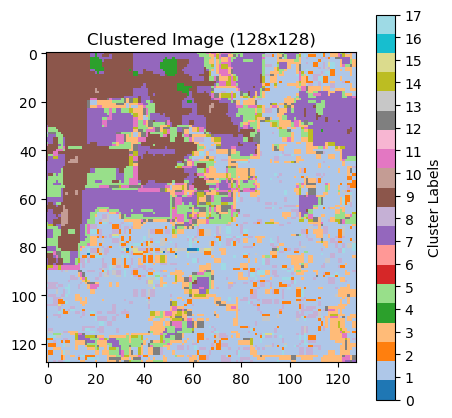

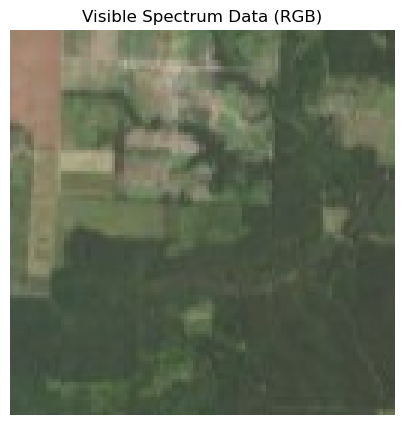

In [ ]:

cmap = plt.get_cmap("tab20", len(cluster_dict))  # Use a colormap with enough distinct colors

# Plot the clustered image
plt.figure(figsize=(5, 5))
plt.imshow(image_clusters, cmap=cmap, interpolation="nearest")
plt.colorbar(ticks=range(len(cluster_dict)), label="Cluster Labels")
plt.title(f"Clustered Image ({square_size}x{square_size})")
plt.show()

# Plot the visible spectrum data as an RGB image
plt.figure(figsize=(5, 5))
rgb_image = data[1, :, :, 10:13]  # Normalize to [0, 1] range for RGB
plt.imshow(rgb_image, interpolation="nearest")
plt.title("Visible Spectrum Data (RGB)")
plt.axis("off")  # Turn off axis for better visualization
plt.show()



In [22]:
# psuedo code for evaluating the som

# evaluate topographic error

topoError = som.topographic_error(reshaped_data)

print(f"Topographic Error: {topoError}")

# vary learning rate and sigma values those are the most important


/home/tcarlyon/miniconda3/envs/keras-tf-v2025/lib/python3.12/site-packages/minisom.py:631: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)


Topographic Error: 0.8002903312444687
